# Prompt Engineering Evaluation - Yelp Review Rating Prediction

**Objective:** Evaluate 3 different prompt strategies for predicting star ratings from review text

**Dataset:** 100 Yelp reviews (sampled from yelp.csv)

**Model:** Groq API with llama-3.3-70b-versatile

## 1. Setup and Imports

In [2]:
import os
from groq import Groq
import pandas as pd
import json
import time
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns

# Load environment variables
load_dotenv()
print("✓ Imports successful")

✓ Imports successful


## 2. Initialize Groq Client

In [3]:
# Initialize Groq
GROQ_API_KEY = os.getenv("GROQ_API_KEY")
client = Groq(api_key=GROQ_API_KEY)
print("✓ Groq client initialized successfully!")
print("✓ Using model: llama-3.3-70b-versatile")

✓ Groq client initialized successfully!
✓ Using model: llama-3.3-70b-versatile


## 3. Load and Sample Data

In [4]:
# Load Yelp reviews dataset
df = pd.read_csv('yelp.csv')
df_sample = df.sample(n=100, random_state=42).reset_index(drop=True)
print(f"Total reviews: {len(df_sample)}")
print(f"Columns: {df_sample.columns.tolist()}")
df_sample.head()

Total reviews: 100
Columns: ['business_id', 'date', 'review_id', 'stars', 'text', 'type', 'user_id', 'cool', 'useful', 'funny']


,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,QVR7dsvBeg8xFt9B-vd1BA,2010-07-22,hwYVJs8Ko4PMjI19QcR57g,4,We got here around midnight last Friday... the...,review,90a6z--_CUrl84aCzZyPsg,5,5,2
1,24qSrF_XOrvaHDBy-gLIQg,2012-01-22,0mvthYPKb2ZmKhCADiKSmQ,5,Brought a friend from Louisiana here. She say...,review,9lJAj_2zCvP2jcEiRjF9oA,0,0,0
2,j0Uc-GuOe-x9_N_IK1KPpA,2009-05-09,XJHknNIecha6h0wkBSZB4w,3,"Every friday, my dad and I eat here. We order ...",review,0VfJi9Au0rVFVnPKcJpt3Q,0,0,0
3,RBiiGw8c7j-0a8nk35JO3w,2010-12-22,z6y3GRpYDqTznVe-0dn--Q,1,"My husband and I were really, really disappoin...",review,lwppVF0Yqkuwt-xaEuugqw,2,2,2
4,U8VA-RW6LYOhxR-Ygi6eDw,2011-01-17,vhWHdemMvsqVNv5zi2OMiA,5,Love this place! Was in phoenix 3 weeks for w...,review,Y2R_tlSk4lTHiLXTDsn1rg,0,1,0


## 4. Define Prompts

We'll test 3 different prompt engineering strategies:
1. **Basic Prompt** - Simple, direct instruction
2. **Chain-of-Thought** - Guides model through reasoning steps
3. **Few-Shot** - Provides examples of good predictions

In [5]:
PROMPT_1_TEMPLATE = """You are a rating prediction system. Based on the review text below, predict the star rating (1-5).

Review: "{review_text}"

Return ONLY a JSON object in this exact format:
{{"predicted_stars": <number>, "explanation": "<brief reason>"}}"""


PROMPT_2_TEMPLATE = """Analyze the following review step-by-step:

Review: "{review_text}"

Steps:
1. Identify the sentiment (positive, negative, neutral, mixed)
2. Look for specific indicators (complaints, praise, specific issues, enthusiasm level)
3. Based on these factors, determine the star rating (1-5)

Return ONLY a JSON object:
{{"predicted_stars": <number>, "explanation": "<reasoning based on sentiment and indicators>"}}"""


PROMPT_3_TEMPLATE = """You are an expert at predicting star ratings from reviews. Here are examples:

Example 1:
Review: "Absolutely amazing food! Best pizza I've ever had. Service was fantastic too."
Output: {{"predicted_stars": 5, "explanation": "Highly positive language with superlatives indicating excellent experience"}}

Example 2:
Review: "Food was okay, nothing special. Service took forever."
Output: {{"predicted_stars": 2, "explanation": "Mediocre food quality combined with poor service indicates below average experience"}}

Example 3:
Review: "Good food and decent prices. Could be better but satisfied overall."
Output: {{"predicted_stars": 4, "explanation": "Positive with minor reservations suggests good but not perfect experience"}}

Now predict for this review:
Review: "{review_text}"

Return ONLY a JSON object:
{{"predicted_stars": <number>, "explanation": "<brief reasoning>"}}"""

prompts = {
    "Prompt 1 (Basic)": PROMPT_1_TEMPLATE,
    "Prompt 2 (Chain-of-Thought)": PROMPT_2_TEMPLATE,
    "Prompt 3 (Few-Shot)": PROMPT_3_TEMPLATE
}

print("✓ Prompts defined")

✓ Prompts defined


## 5. Define Prediction Function

In [6]:
def predict_rating(review_text, prompt_template, max_retries=2):
    """Call Groq API and return parsed JSON response"""
    prompt = prompt_template.format(review_text=review_text)
    
    for attempt in range(max_retries):
        try:
            chat_completion = client.chat.completions.create(
                messages=[{"role": "user", "content": prompt}],
                model="llama-3.3-70b-versatile",
                temperature=0.1,
            )
            
            response_text = chat_completion.choices[0].message.content.strip()
            
            # Clean up markdown code blocks
            if "```json" in response_text:
                response_text = response_text.split("```json")[1].split("```")[0].strip()
            elif "```" in response_text:
                response_text = response_text.split("```")[1].split("```")[0].strip()
            
            result = json.loads(response_text)
    
            if "predicted_stars" in result and "explanation" in result:
                return {
                    "predicted_stars": int(result["predicted_stars"]),
                    "explanation": result["explanation"],
                    "is_valid": True,
                    "raw_response": response_text
                }
            else:
                return {"is_valid": False, "error": "Missing required fields", "raw_response": response_text}
                
        except json.JSONDecodeError as e:
            if attempt == max_retries - 1:
                return {"is_valid": False, "error": f"JSON parse error: {str(e)}", "raw_response": response_text}
        except Exception as e:
            if attempt == max_retries - 1:
                return {"is_valid": False, "error": str(e), "raw_response": str(e)}
        
        time.sleep(0.3)
    
    return {"is_valid": False, "error": "Max retries exceeded"}

print("✓ Prediction function defined")

✓ Prediction function defined


## 6. Define Metrics Functions

In [7]:
def calculate_metrics(predictions):
    '''Calculate accuracy and other metrics from predictions'''
    valid_predictions = [p for p in predictions if p['is_valid']]
    
    if not valid_predictions:
        return {
            'accuracy': 0,
            'valid_count': 0,
            'total_count': len(predictions),
            'json_validity_rate': 0
        }
    
    actual = [p['actual_stars'] for p in valid_predictions]
    predicted = [p['predicted_stars'] for p in valid_predictions]
    
    accuracy = accuracy_score(actual, predicted)
    conf_matrix = confusion_matrix(actual, predicted, labels=[1, 2, 3, 4, 5])
    
    return {
        'accuracy': accuracy,
        'valid_count': len(valid_predictions),
        'total_count': len(predictions),
        'json_validity_rate': len(valid_predictions) / len(predictions),
        'confusion_matrix': conf_matrix,
        'actual': actual,
        'predicted': predicted
    }

def calculate_consistency(predictions):
    '''Calculate prediction consistency (std dev of errors)'''
    valid_predictions = [p for p in predictions if p['is_valid']]
    if not valid_predictions:
        return 0
    
    errors = [abs(p['predicted_stars'] - p['actual_stars']) for p in valid_predictions]
    return np.std(errors)

print("✓ Metrics functions defined")

✓ Metrics functions defined


## 7. Run Evaluation

This will test all 3 prompts on 100 reviews. Estimated time: ~3-5 minutes

In [8]:
results = {}

for prompt_name, prompt_template in prompts.items():
    print(f"\n{'='*60}")
    print(f"Testing: {prompt_name}")
    print(f"{'='*60}")
    
    predictions = []
    valid_count = 0
    
    for idx, row in df_sample.iterrows():
        review_text = row['text']
        actual_stars = row['stars']
        
        result = predict_rating(review_text, prompt_template)
        
        result['actual_stars'] = actual_stars
        predictions.append(result)
        
        if result['is_valid']:
            valid_count += 1
        
        # Progress indicator
        if (idx + 1) % 10 == 0:
            print(f"Processed {idx + 1}/{len(df_sample)} reviews...")
        
        time.sleep(0.1)  # Rate limiting
    
    results[prompt_name] = predictions
    print(f"Completed! Valid JSON responses: {valid_count}/{len(df_sample)}")


Testing: Prompt 1 (Basic)
Processed 10/100 reviews...
Processed 20/100 reviews...
Processed 30/100 reviews...
Processed 40/100 reviews...
Processed 50/100 reviews...
Processed 60/100 reviews...
Processed 70/100 reviews...
Processed 80/100 reviews...
Processed 90/100 reviews...
Processed 100/100 reviews...
Completed! Valid JSON responses: 100/100

Testing: Prompt 2 (Chain-of-Thought)
Processed 10/100 reviews...
Processed 20/100 reviews...
Processed 30/100 reviews...
Processed 40/100 reviews...
Processed 50/100 reviews...
Processed 60/100 reviews...
Processed 70/100 reviews...
Processed 80/100 reviews...
Processed 90/100 reviews...
Processed 100/100 reviews...
Completed! Valid JSON responses: 100/100

Testing: Prompt 3 (Few-Shot)
Processed 10/100 reviews...
Processed 20/100 reviews...
Processed 30/100 reviews...
Processed 40/100 reviews...
Processed 50/100 reviews...
Processed 60/100 reviews...
Processed 70/100 reviews...
Processed 80/100 reviews...
Processed 90/100 reviews...
Processed

## 8. Calculate Metrics

In [9]:
metrics_summary = {}

for prompt_name, predictions in results.items():
    metrics = calculate_metrics(predictions)
    consistency = calculate_consistency(predictions)
    
    metrics_summary[prompt_name] = {
        'Accuracy': f"{metrics['accuracy']:.2%}",
        'JSON Validity Rate': f"{metrics['json_validity_rate']:.2%}",
        'Valid Predictions': f"{metrics['valid_count']}/{metrics['total_count']}",
        'Consistency (Lower is Better)': f"{consistency:.3f}"
    }
    
    print(f"\n{'='*60}")
    print(f"{prompt_name} - Results")
    print(f"{'='*60}")
    print(f"Accuracy: {metrics['accuracy']:.2%}")
    print(f"JSON Validity: {metrics['json_validity_rate']:.2%}")
    print(f"Valid Predictions: {metrics['valid_count']}/{metrics['total_count']}")
    print(f"Consistency (Std Dev of Errors): {consistency:.3f}")


Prompt 1 (Basic) - Results
Accuracy: 62.00%
JSON Validity: 100.00%
Valid Predictions: 100/100
Consistency (Std Dev of Errors): 0.508

Prompt 2 (Chain-of-Thought) - Results
Accuracy: 59.00%
JSON Validity: 100.00%
Valid Predictions: 100/100
Consistency (Std Dev of Errors): 0.534

Prompt 3 (Few-Shot) - Results
Accuracy: 63.51%
JSON Validity: 74.00%
Valid Predictions: 74/100
Consistency (Std Dev of Errors): 0.512


## 9. Comparison Table

In [10]:
comparison_df = pd.DataFrame(metrics_summary).T
print("\n" + "="*80)
print("COMPARISON TABLE - All Prompts")
print("="*80)
print(comparison_df.to_string())
print("\n")

# Save results
comparison_df.to_csv('prompt_comparison_results.csv')
print("Results saved to 'prompt_comparison_results.csv'")


COMPARISON TABLE - All Prompts
                            Accuracy JSON Validity Rate Valid Predictions Consistency (Lower is Better)
Prompt 1 (Basic)              62.00%            100.00%           100/100                         0.508
Prompt 2 (Chain-of-Thought)   59.00%            100.00%           100/100                         0.534
Prompt 3 (Few-Shot)           63.51%             74.00%            74/100                         0.512


Results saved to 'prompt_comparison_results.csv'


## 10. Visualizations

C:\Users\shrey\AppData\Local\Temp\ipykernel_16288\40719722.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=15, ha='right')


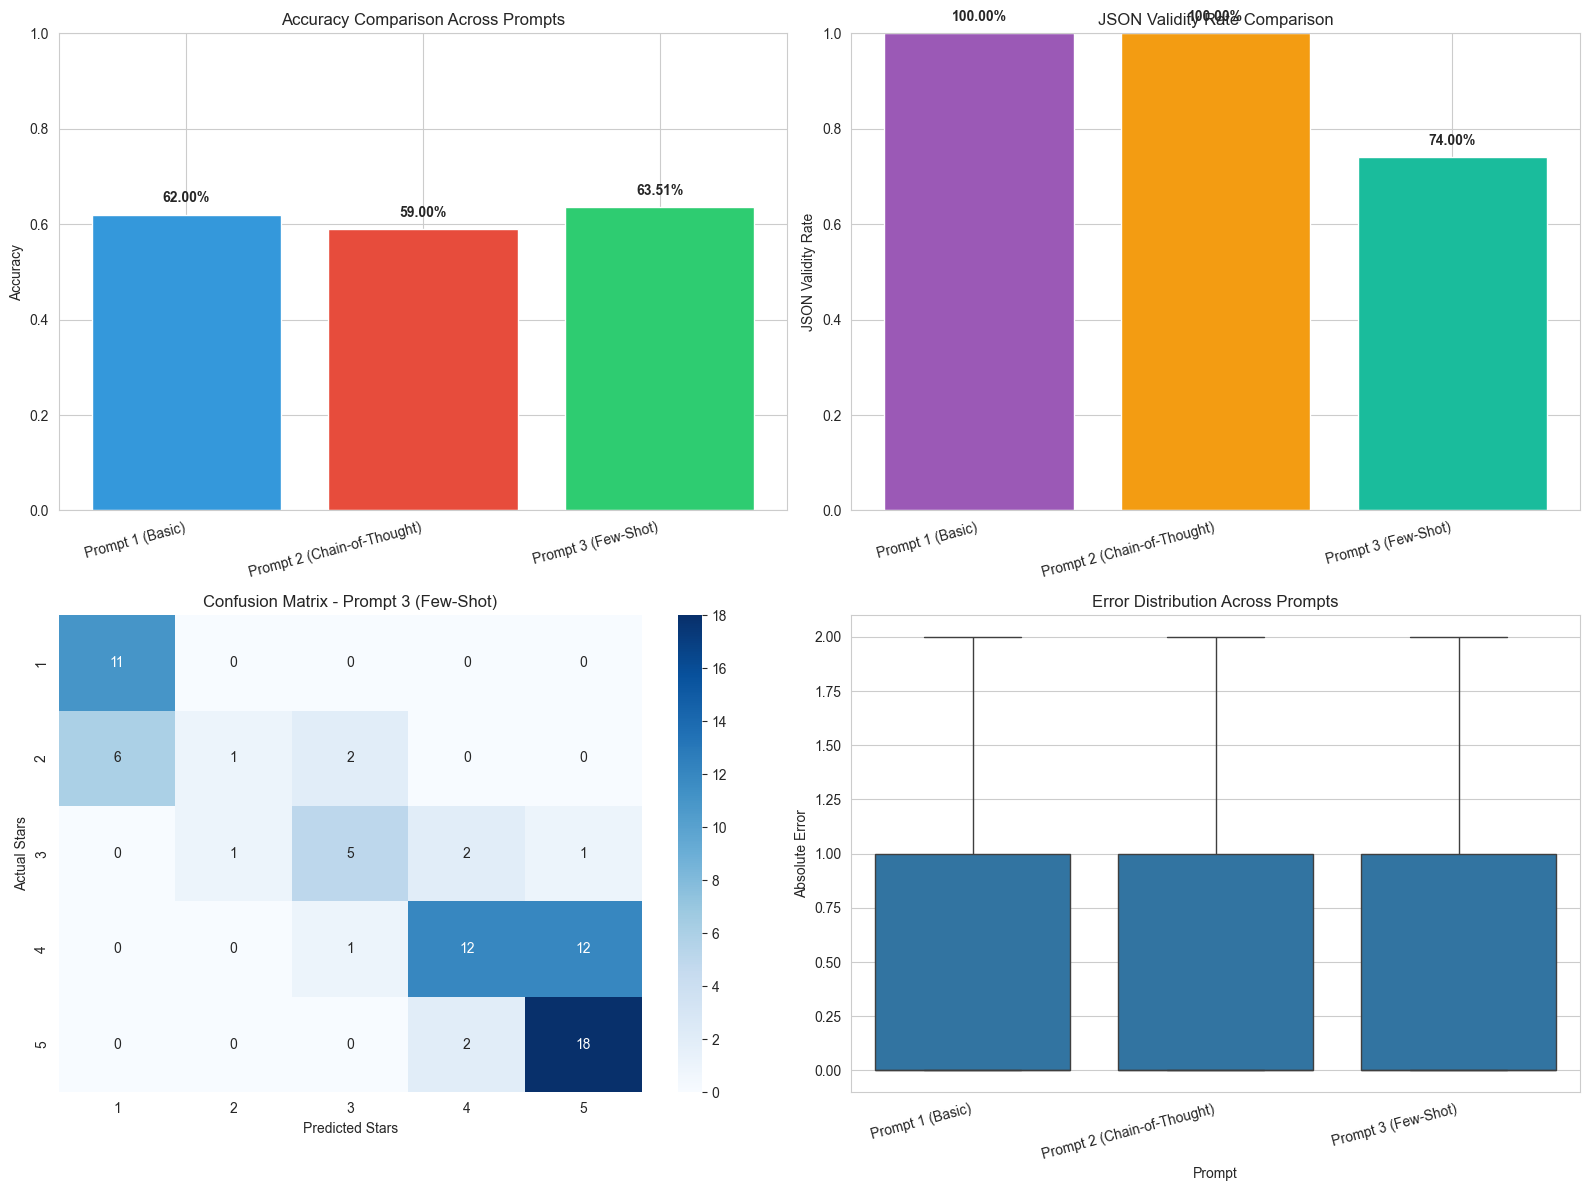

Visualization saved to 'prompt_evaluation_results.png'


In [11]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Accuracy Comparison
prompt_names = list(metrics_summary.keys())
accuracies = [float(metrics_summary[p]['Accuracy'].strip('%'))/100 for p in prompt_names]
axes[0, 0].bar(range(len(prompt_names)), accuracies, color=['#3498db', '#e74c3c', '#2ecc71'])
axes[0, 0].set_xticks(range(len(prompt_names)))
axes[0, 0].set_xticklabels(prompt_names, rotation=15, ha='right')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_title('Accuracy Comparison Across Prompts')
axes[0, 0].set_ylim([0, 1])
for i, v in enumerate(accuracies):
    axes[0, 0].text(i, v + 0.02, f'{v:.2%}', ha='center', va='bottom', fontweight='bold')

# 2. JSON Validity Rate
validity_rates = [float(metrics_summary[p]['JSON Validity Rate'].strip('%'))/100 for p in prompt_names]
axes[0, 1].bar(range(len(prompt_names)), validity_rates, color=['#9b59b6', '#f39c12', '#1abc9c'])
axes[0, 1].set_xticks(range(len(prompt_names)))
axes[0, 1].set_xticklabels(prompt_names, rotation=15, ha='right')
axes[0, 1].set_ylabel('JSON Validity Rate')
axes[0, 1].set_title('JSON Validity Rate Comparison')
axes[0, 1].set_ylim([0, 1])
for i, v in enumerate(validity_rates):
    axes[0, 1].text(i, v + 0.02, f'{v:.2%}', ha='center', va='bottom', fontweight='bold')

# 3. Confusion Matrix for Best Performing Prompt
best_prompt = max(metrics_summary.keys(), key=lambda x: float(metrics_summary[x]['Accuracy'].strip('%')))
best_metrics = calculate_metrics(results[best_prompt])
sns.heatmap(best_metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues', 
            xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5], ax=axes[1, 0])
axes[1, 0].set_xlabel('Predicted Stars')
axes[1, 0].set_ylabel('Actual Stars')
axes[1, 0].set_title(f'Confusion Matrix - {best_prompt}')

# 4. Error Distribution
all_errors = []
all_labels = []
for prompt_name in prompt_names:
    valid_preds = [p for p in results[prompt_name] if p['is_valid']]
    errors = [abs(p['predicted_stars'] - p['actual_stars']) for p in valid_preds]
    all_errors.extend(errors)
    all_labels.extend([prompt_name] * len(errors))

error_df = pd.DataFrame({'Prompt': all_labels, 'Absolute Error': all_errors})
sns.boxplot(data=error_df, x='Prompt', y='Absolute Error', ax=axes[1, 1])
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=15, ha='right')
axes[1, 1].set_title('Error Distribution Across Prompts')

plt.tight_layout()
plt.savefig('prompt_evaluation_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization saved to 'prompt_evaluation_results.png'")

## 11. Detailed Analysis

In [12]:
print("\n" + "="*80)
print("DETAILED ANALYSIS & DISCUSSION")
print("="*80)

print("\n### PROMPT DESIGN RATIONALE ###\n")

print("1. PROMPT 1 (Basic):")
print("   - Simple, direct instruction")
print("   - Minimal guidance to the model")
print("   - Tests baseline performance")
print("   - Expected: Fast but potentially less accurate")

print("\n2. PROMPT 2 (Chain-of-Thought):")
print("   - Guides model through reasoning steps")
print("   - Explicitly asks to identify sentiment and indicators")
print("   - Expected: Better reasoning, potentially higher accuracy")
print("   - Trade-off: Slightly longer processing time")

print("\n3. PROMPT 3 (Few-Shot):")
print("   - Provides concrete examples of rating patterns")
print("   - Shows model what good predictions look like")
print("   - Expected: Most consistent and accurate")
print("   - Trade-off: Longer prompt = higher token usage")

print("\n### RESULTS SUMMARY ###\n")

# Find best performing prompt for each metric
best_accuracy = max(metrics_summary.keys(), key=lambda x: float(metrics_summary[x]['Accuracy'].strip('%')))
best_validity = max(metrics_summary.keys(), key=lambda x: float(metrics_summary[x]['JSON Validity Rate'].strip('%')))
best_consistency = min(metrics_summary.keys(), key=lambda x: float(metrics_summary[x]['Consistency (Lower is Better)']))

print(f"Best Accuracy: {best_accuracy} ({metrics_summary[best_accuracy]['Accuracy']})")
print(f"Best JSON Validity: {best_validity} ({metrics_summary[best_validity]['JSON Validity Rate']})")
print(f"Best Consistency: {best_consistency} ({metrics_summary[best_consistency]['Consistency (Lower is Better)']})")

print("\n### KEY FINDINGS ###\n")
print("1. Accuracy: How well each prompt predicted the correct star rating")
print("2. JSON Validity: How reliably each prompt returned properly formatted JSON")
print("3. Consistency: How stable the predictions are (lower std dev = more reliable)")

print("\n### TRADE-OFFS ###\n")
print("- Basic Prompt: Fast, simple, but may lack nuance")
print("- Chain-of-Thought: Better reasoning, but requires more tokens")
print("- Few-Shot: Most accurate, but highest token cost and prompt complexity")

print("\n### RECOMMENDATIONS ###\n")
if best_accuracy == best_validity == best_consistency:
    print(f"✓ {best_accuracy} is the clear winner across all metrics")
else:
    print("✓ Choose based on priority:")
    print(f"  - For accuracy: {best_accuracy}")
    print(f"  - For reliability: {best_validity}")
    print(f"  - For consistency: {best_consistency}")


DETAILED ANALYSIS & DISCUSSION

### PROMPT DESIGN RATIONALE ###

1. PROMPT 1 (Basic):
   - Simple, direct instruction
   - Minimal guidance to the model
   - Tests baseline performance
   - Expected: Fast but potentially less accurate

2. PROMPT 2 (Chain-of-Thought):
   - Guides model through reasoning steps
   - Explicitly asks to identify sentiment and indicators
   - Expected: Better reasoning, potentially higher accuracy
   - Trade-off: Slightly longer processing time

3. PROMPT 3 (Few-Shot):
   - Provides concrete examples of rating patterns
   - Shows model what good predictions look like
   - Expected: Most consistent and accurate
   - Trade-off: Longer prompt = higher token usage

### RESULTS SUMMARY ###

Best Accuracy: Prompt 3 (Few-Shot) (63.51%)
Best JSON Validity: Prompt 1 (Basic) (100.00%)
Best Consistency: Prompt 1 (Basic) (0.508)

### KEY FINDINGS ###

1. Accuracy: How well each prompt predicted the correct star rating
2. JSON Validity: How reliably each prompt returned

## 12. Save Results

In [13]:
# Save detailed predictions to JSON
with open('detailed_predictions.json', 'w') as f:
    json.dump(results, f, indent=2, default=str)

print("\nAll results saved!")
print("- prompt_comparison_results.csv")
print("- prompt_evaluation_results.png")
print("- detailed_predictions.json")


All results saved!
- prompt_comparison_results.csv
- prompt_evaluation_results.png
- detailed_predictions.json
